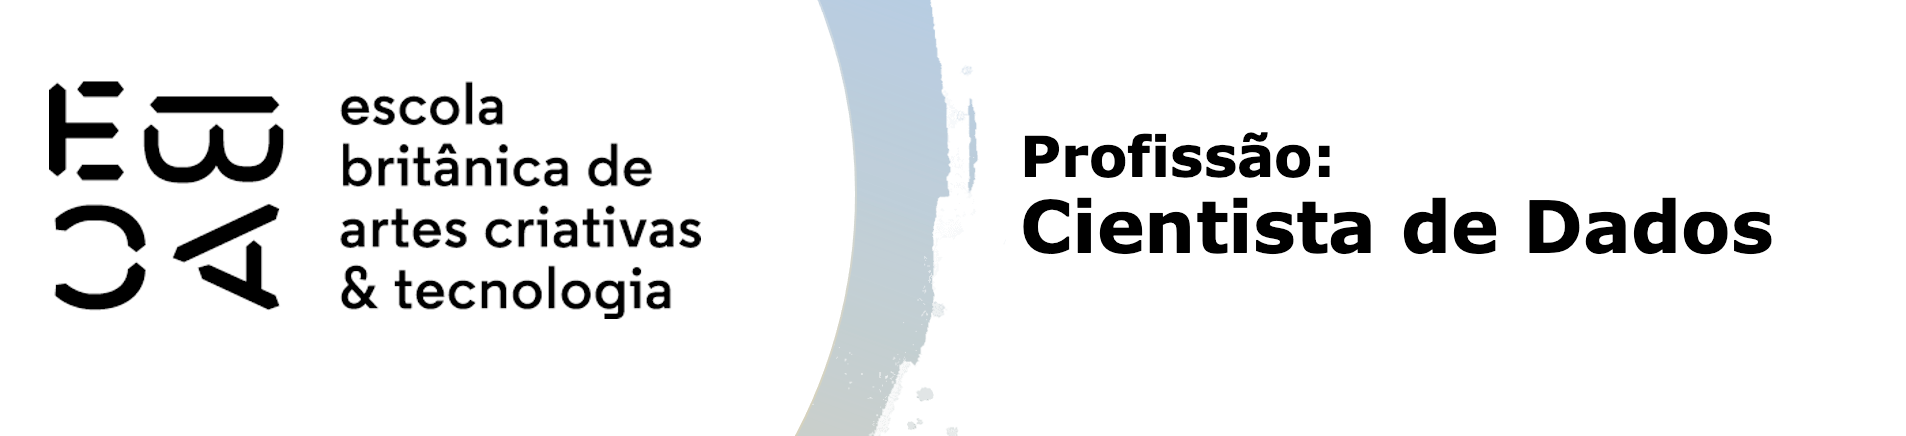

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187646 entries, 0 to 187645
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CNPJ emit.           187646 non-null  object        
 1   Emitente             187646 non-null  object        
 2   No.                  187646 non-null  int64         
 3   Data Emissão         187646 non-null  datetime64[ns]
 4   Valor NF             187646 non-null  float64       
 5   Data Registro        187646 non-null  datetime64[ns]
 6   Créditos             187646 non-null  float64       
 7   Situação do Crédito  187646 non-null  category      
 8   Ano                  187646 non-null  int64         
 9   Semestre             187646 non-null  int64         
 10  Retorno              186666 non-null  float64       
 11  flag_credito         187646 non-null  int64         
 12  categoria            187646 non-null  object        
dtypes: category(1)

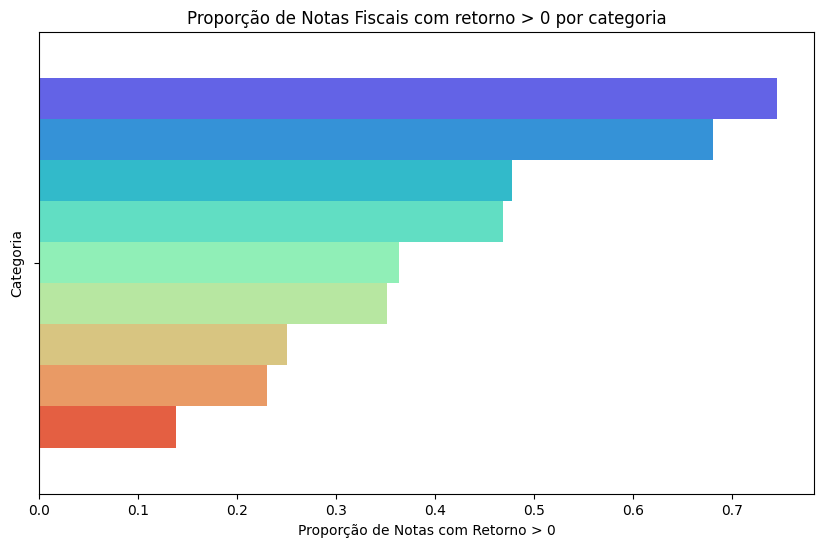

In [18]:
# Filtrar dados a partir de janeiro de 2020
df_2020 = df[df['Data Emissão'] >= '2020-01-01'].copy()

# Criar uma coluna para indicar se o retorno é maior que 0
df_2020.loc[:, 'retorno_maior_que_zero'] = df_2020['Retorno'] > 0

# Calcular a proporção de notas com retorno > 0 por categoria
proporcao_retorno = df_2020.groupby('categoria')['retorno_maior_que_zero'].mean().reset_index()

# Ordenar as categorias pela proporção de retorno
proporcao_retorno = proporcao_retorno.sort_values(by='retorno_maior_que_zero', ascending=False)

# Gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(data=proporcao_retorno, x='retorno_maior_que_zero', hue='categoria', legend=False, palette='rainbow')
plt.xlabel('Proporção de Notas com Retorno > 0')
plt.ylabel('Categoria')
plt.title('Proporção de Notas Fiscais com retorno > 0 por categoria')
plt.show();

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

In [21]:
# Calcular o número de eventos (retorno > 0) e não-eventos para cada categoria
event_counts = df_2020[df_2020['retorno_maior_que_zero']].groupby('categoria').size()
non_event_counts = df_2020[~df_2020['retorno_maior_que_zero']].groupby('categoria').size()

# Calcular as proporções
total_events = event_counts.sum()
total_non_events = non_event_counts.sum()

proporcao_eventos = event_counts / total_events
proporcao_nao_eventos = non_event_counts / total_non_events

# Calcular WOE
woe = np.log(proporcao_eventos / proporcao_nao_eventos)

In [22]:
# DataFrame com os resultados
woe_df = pd.DataFrame(
    {
        'proporcao_eventos': proporcao_eventos,
        'proporcao_nao_eventos': proporcao_nao_eventos,
        'WOE': woe
    }
).reset_index().fillna(0)

In [23]:
# Tabela de WOE
print(woe_df)

      categoria  proporcao_eventos  proporcao_nao_eventos       WOE
0     Alimentos           0.092234               0.032395  1.046342
1    Auto posto           0.003618               0.008159 -0.813331
2    Construção           0.201592               0.171723  0.160360
3      Farmácia           0.095986               0.133104 -0.326928
4       Mercado           0.353100               0.289718  0.197846
5  Restaurantes           0.043571               0.011141  1.363801
6        Varejo           0.018785               0.087937 -1.543585
7     Vestuário           0.011871               0.029755 -0.918918
8  não definido           0.179243               0.236069 -0.275381


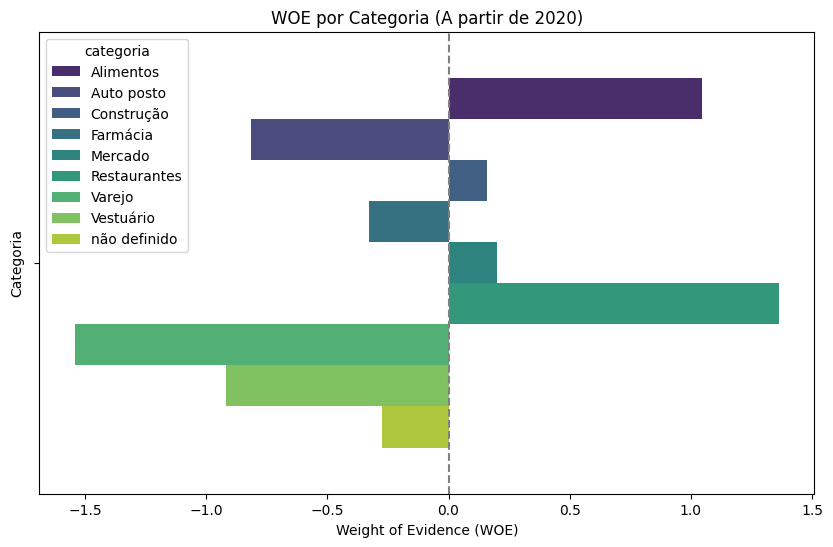

In [25]:
# Gráfico de WOE
plt.figure(figsize=(10, 6))
sns.barplot(data=woe_df, x='WOE', hue='categoria', palette='viridis')
plt.xlabel('Weight of Evidence (WOE)')
plt.ylabel('Categoria')
plt.title('WOE por Categoria (A partir de 2020)')
plt.axvline(0, color='grey', ls='--')
plt.show();

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [26]:
# Calcular Information Value (IV)
woe_df['IV'] = (woe_df['proporcao_eventos'] - woe_df['proporcao_nao_eventos']) * woe_df['WOE']
information_value = woe_df['IV'].sum()

In [27]:
# Mostrar o Information Value
print(f'Information Value: {information_value:.4f}')

Information Value: 0.2788


In [28]:
# Tabela de WOE e IV
print(woe_df)

      categoria  proporcao_eventos  proporcao_nao_eventos       WOE        IV
0     Alimentos           0.092234               0.032395  1.046342  0.062613
1    Auto posto           0.003618               0.008159 -0.813331  0.003694
2    Construção           0.201592               0.171723  0.160360  0.004790
3      Farmácia           0.095986               0.133104 -0.326928  0.012135
4       Mercado           0.353100               0.289718  0.197846  0.012540
5  Restaurantes           0.043571               0.011141  1.363801  0.044229
6        Varejo           0.018785               0.087937 -1.543585  0.106742
7     Vestuário           0.011871               0.029755 -0.918918  0.016434
8  não definido           0.179243               0.236069 -0.275381  0.015649


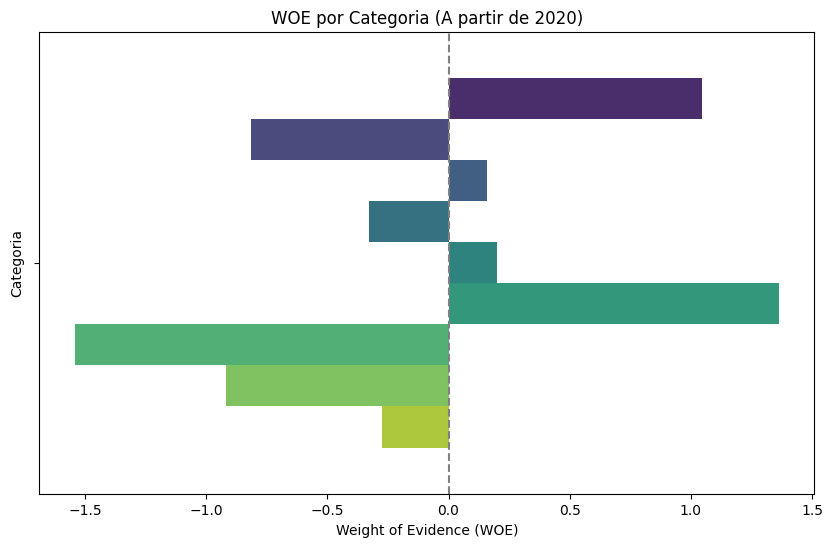

In [31]:
# Gráfico de WOE
plt.figure(figsize=(10, 6))
sns.barplot(data=woe_df, x='WOE', hue='categoria', legend=False, palette='viridis')
plt.xlabel('Weight of Evidence (WOE)')
plt.ylabel('Categoria')
plt.title('WOE por Categoria (A partir de 2020)')
plt.axvline(0, color='grey', linestyle='--')
plt.show()

## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


<p style='color: green'>O IV possui um valor entre 0.1 e 0.3, indicando que a variável categórcia tem um valor preditivo moderado ou médio.</p>
<p style='color: green'>Isso significa que a variável é razoavelmente boa em discriminar entre as notas que têm e não têm retorno, mas não é a única variável a ser considerada.</p>